# Étape 1 : Importer les bibliothèques nécessaires


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import Counter
import numpy as np


# Étape 2 : Construction du vocabulaire et des fonctions d'encodage



In [2]:
# Fonction pour créer un vocabulaire à partir de données textuelles

def build_vocab(texts, special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"]):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {token: idx for idx, token in enumerate(special_tokens + list(counter.keys()))}
    return vocab
# Fonction permettant d'encoder les phrases en indices avec remplissage
def encode_sentence(text, vocab, max_len):
    tokens = ["<bos>"] + text.split() + ["<eos>"]
    tokens = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    tokens += [vocab["<pad>"]] * (max_len - len(tokens))
    return tokens[:max_len]

df = pd.read_csv("/kaggle/input/traduction/sentences (1).csv")  
df['darija'] = df['darija'].fillna("").astype(str)
df['eng'] = df['eng'].fillna("").astype(str)
vocab_darija = build_vocab(df['darija'])
vocab_eng = build_vocab(df['eng'])

# Étape 3 : Classe de données personnalisée pour le modèle de traduction

In [3]:
class TranslationDataset(Dataset):
    def __init__(self, data, input_vocab, output_vocab, max_len=20):
        self.data = data
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        darija_text = self.data.iloc[idx]['darija']
        eng_text = self.data.iloc[idx]['eng']
        input_seq = encode_sentence(darija_text, self.input_vocab, self.max_len)
        output_seq = encode_sentence(eng_text, self.output_vocab, self.max_len)
        return torch.tensor(input_seq), torch.tensor(output_seq)


# Étape 4 : Définir les modèles d'encodeur et de décodeur


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
    
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, trg, hidden, cell):
        trg = trg.unsqueeze(1)
        embedded = self.embedding(trg)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell


# Etape 5: Modèle Seq2Seq


In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        
        trg_token = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(trg_token, hidden, cell)
            outputs[:, t] = output
            top1 = output.argmax(1)
            trg_token = trg[:, t] if np.random.random() < teacher_forcing_ratio else top1
        return outputs

# Etape 6 : fonction d'entrainement 

In [13]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        output = model(src, trg)
        
        loss = criterion(output.view(-1, output_dim), trg.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        _, predicted_tokens = torch.max(output, dim=2)
        non_pad_elements = (trg != vocab_eng["<pad>"])
        correct = (predicted_tokens == trg) & non_pad_elements
        total_correct += correct.sum().item()
        total_count += non_pad_elements.sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_count  

    return avg_loss, accuracy



# Étape 7 : Initialisation du modèle et boucle de training

Epoch 1 - Loss: 5.8156, Accuracy: 21.17%
Epoch 2 - Loss: 5.1941, Accuracy: 27.15%
Epoch 3 - Loss: 4.8817, Accuracy: 29.49%
Epoch 4 - Loss: 4.6026, Accuracy: 31.52%
Epoch 5 - Loss: 4.3361, Accuracy: 33.62%
Epoch 6 - Loss: 4.0705, Accuracy: 36.00%
Epoch 7 - Loss: 3.8137, Accuracy: 38.79%
Epoch 8 - Loss: 3.5503, Accuracy: 42.02%
Epoch 9 - Loss: 3.3204, Accuracy: 45.34%
Epoch 10 - Loss: 3.0769, Accuracy: 49.38%
Epoch 11 - Loss: 2.8579, Accuracy: 53.28%
Epoch 12 - Loss: 2.6597, Accuracy: 57.13%
Epoch 13 - Loss: 2.4756, Accuracy: 60.76%
Epoch 14 - Loss: 2.3051, Accuracy: 64.33%
Epoch 15 - Loss: 2.1621, Accuracy: 67.51%
Epoch 16 - Loss: 2.0310, Accuracy: 70.50%
Epoch 17 - Loss: 1.9208, Accuracy: 72.97%
Epoch 18 - Loss: 1.8182, Accuracy: 75.21%
Epoch 19 - Loss: 1.7410, Accuracy: 77.06%
Epoch 20 - Loss: 1.6638, Accuracy: 78.88%
Model and vocabularies saved in saved_model


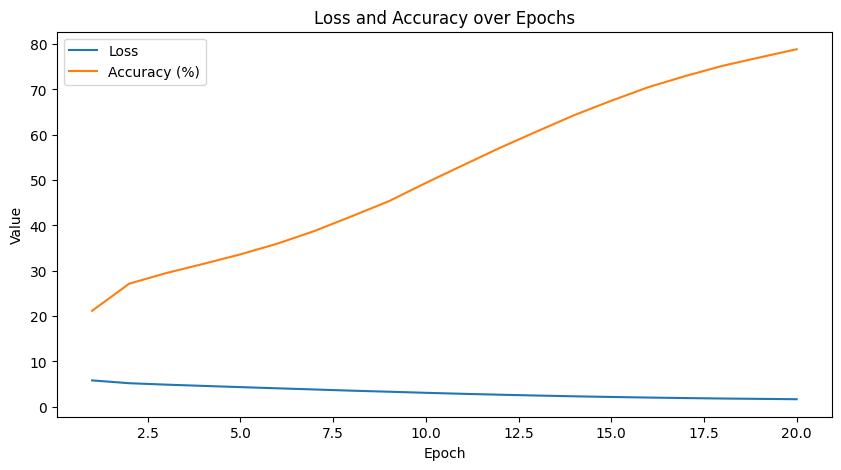

In [15]:
import os
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paramètres du modèle
input_dim = len(vocab_darija)
output_dim = len(vocab_eng)
emb_dim = 256
hidden_dim = 512

# Initialisation des composants du modèle
encoder = Encoder(input_dim, emb_dim, hidden_dim)
decoder = Decoder(output_dim, emb_dim, hidden_dim)
model = Seq2Seq(encoder, decoder, device).to(device)

train_dataset = TranslationDataset(df, vocab_darija, vocab_eng)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_eng["<pad>"])

loss_values = []
accuracy_values = []

# Boucle d'entraînement
for epoch in range(20):
    loss, accuracy = train_model(model, train_dataloader, optimizer, criterion, device)
    loss_values.append(loss)
    accuracy_values.append(accuracy * 100)  # Conversion en pourcentage
    print(f"Epoch {epoch+1} - Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%")
    
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
torch.save(model.state_dict(), os.path.join(model_dir, "seq2seq_model.pth"))
with open(os.path.join(model_dir, "vocab_darija.pkl"), "wb") as f:
    pickle.dump(vocab_darija, f)
with open(os.path.join(model_dir, "vocab_eng.pkl"), "wb") as f:
    pickle.dump(vocab_eng, f)
print(f"Model and vocabularies saved in {model_dir}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), loss_values, label="Loss")
plt.plot(range(1, 21), accuracy_values, label="Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Loss and Accuracy over Epochs")
plt.legend()
plt.show()


# Etape 8 : fonction de traduction 

In [16]:
def translate_sentence(model, sentence, input_vocab, output_vocab, max_len, device):
    model.eval()
    tokens = encode_sentence(sentence, input_vocab, max_len)
    src = torch.tensor(tokens).unsqueeze(0).to(device)
    
    with torch.no_grad():
        hidden, cell = model.encoder(src)
        trg_indices = [output_vocab["<bos>"]]
        
        for _ in range(max_len):
            trg_tensor = torch.tensor([trg_indices[-1]]).to(device)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            pred_token = output.argmax(1).item()
            trg_indices.append(pred_token)
            if pred_token == output_vocab["<eos>"]:
                break
    
    translated_sentence = [list(output_vocab.keys())[list(output_vocab.values()).index(i)] for i in trg_indices]
    return translated_sentence[1:-1] 

In [20]:
sentence = "salam" 
translated_sentence = translate_sentence(model, sentence, vocab_darija, vocab_eng, max_len=50, device=device)
print("Phrase traduite:", " ".join(translated_sentence))


Phrase traduite: Hello
